In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tests.leandro.mini_connectome import *
from tests.leandro.plots import *
from omegaconf import OmegaConf
from data._main import *
from statsmodels.tsa.stattools import grangercausalitytests
import torch
from torch.utils.data import DataLoader, random_split, ConcatDataset

In [3]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

def check_stationarity(timeseries, verbose=False):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    if verbose:
        print('Results of Dickey-Fuller Test:')
        print(dfoutput)
    return  dfoutput

In [4]:
import warnings
from statsmodels.tsa.stattools import grangercausalitytests

def granger_causality_analysis(x, y, maxlag=10, verbose=False):
    """
    Perform Granger causality analysis between two time series vectors.

    Args:
        x (array-like): First time series vector.
        y (array-like): Second time series vector.
        maxlag (int): Maximum lag order to consider (default: 10).
        verbose (bool): Whether to print the results (default: False).

    Returns:
        dict: Dictionary containing the Granger causality test results.

    """
    # Convert the input arrays to numpy arrays if needed
    x = np.asarray(x)
    y = np.asarray(y)

    # Reshape the input arrays to be 2-dimensional
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)

    # Combine the input arrays into a single 2-dimensional array
    data = np.concatenate((x, y), axis=1) # y causes x?

    # Suppress the warning
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        # Perform the Granger causality test
        results = grangercausalitytests(data, maxlag=maxlag, verbose=verbose)

    return results

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(time, series, lags=30):
    """
    Plot the Autocorrelation Function (ACF), Partial Autocorrelation Function (PACF),
    and the time series in a grid layout.

    Args:
        series (array-like): Time series data.
        lags (int): Number of lags to consider (default: 30).

    Returns:
        None

    """

    # Convert series to numpy array, just in case
    series = np.asarray(series)

    fig = plt.figure(figsize=(14,5))

    # Plot ACF
    ax1 = fig.add_subplot(2, 2, 1)
    plot_acf(series, ax=ax1, lags=lags)
    ax1.set_title('ACF')
    ax1.set_xlabel('Lag (in time steps)')
    ax1.set_ylabel('Autocorrelation')

    # Plot PACF
    ax2 = fig.add_subplot(2, 2, 2)
    plot_pacf(series, ax=ax2, lags=lags)
    ax2.set_title('PACF')
    ax2.set_xlabel('Lag (in time steps)')
    ax2.set_ylabel('Partial Autocorrelation')

    # Plot the time series itself
    ax3 = fig.add_subplot(2, 1, 2)
    ax3.plot(time, series)
    ax3.set_title('Neural activity')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Calcium signal')

    plt.tight_layout()
    plt.show()


In [6]:
miniconnectome = MiniConnectome(direction='TD', group_by='four')
connected_to_M3L = miniconnectome.get_connected_neurons('M3L', index=False)
miniconnectome.minigraph.add_nodes('M3L', connected_to_M3L)
miniconnectome.minigraph.add_nodes(connected_to_M3L[0], miniconnectome.get_connected_neurons(connected_to_M3L[0], index=False))
miniconnectome.minigraph.add_nodes(connected_to_M3L[1], miniconnectome.get_connected_neurons(connected_to_M3L[1], index=False))

for neuron_name in ['I4', 'I6', 'M3R', 'I2L', 'I2R']:
    connected_neurons = miniconnectome.get_connected_neurons(neuron_name, index=False)
    if 'NSML' in connected_neurons:
        miniconnectome.minigraph.add_nodes(neuron_name, ['NSML'])
    if 'NSMR' in connected_neurons:
        miniconnectome.minigraph.add_nodes(neuron_name, ['NSMR'])

miniconnectome.minigraph.display(save=False, filename='M3L.png')
#miniconnectome.minigraph.print()

My goal here is to study the interdependence between the M3L and NSML/NSMR signals.

In [7]:
config = OmegaConf.load("/home/lrvnc/Projects/worm-graph/conf/dataset.yaml")
dataset = get_dataset(config)

Chosen dataset(s): ['Flavell2023']
Num. worms: 50



In [8]:
dataset['worm0'].keys()

dict_keys(['dataset', 'smooth_method', 'worm', 'calcium_data', 'smooth_calcium_data', 'residual_calcium', 'smooth_residual_calcium', 'max_timesteps', 'time_in_seconds', 'dt', 'num_neurons', 'num_named_neurons', 'num_unknown_neurons', 'named_neurons_mask', 'unknown_neurons_mask', 'neurons_mask', 'slot_to_named_neuron', 'named_neuron_to_slot', 'slot_to_unknown_neuron', 'unknown_neuron_to_slot', 'slot_to_neuron', 'neuron_to_slot'])

In [9]:
# Create a dataframe to save the M3L, NSMR and NSML calcium signals
temp_dict = {
    'wormID': [],
    'Time vector': [],
    'M3L data': [],
    'M3L res data': [],
    'NSMR data': [],
    'NSMR res data': [],
    'NSML data': [],
    'NSML res data': []
}

for wormID, data in dataset.items():
    neuron_names = [value for key, value in data['slot_to_named_neuron'].items()]
    if ('M3L' in neuron_names) and ('NSML' in neuron_names) and ('NSMR' in neuron_names):
        X_t = data['smooth_calcium_data'] # (time, all neurons)

        m3l_data = np.asarray(X_t[:, data['named_neuron_to_slot']['M3L']])
        nmsl_data = np.asarray(X_t[:, data['named_neuron_to_slot']['NSML']])
        nmsr_data = np.asarray(X_t[:, data['named_neuron_to_slot']['NSMR']])

        dX_dt = data['smooth_residual_calcium'] # (time, all neurons)

        m3l_res_data = np.asarray(dX_dt[:, data['named_neuron_to_slot']['M3L']])
        nmsl_res_data = np.asarray(dX_dt[:, data['named_neuron_to_slot']['NSML']])
        nmsr_res_data = np.asarray(dX_dt[:, data['named_neuron_to_slot']['NSMR']])

        # Append the data to the dataframe
        temp_dict['wormID'].append(wormID)
        temp_dict['Time vector'].append(np.asarray(data['time_in_seconds']))
        temp_dict['M3L data'].append(m3l_data)
        temp_dict['M3L res data'].append(m3l_res_data)
        temp_dict['NSMR data'].append(nmsr_data)
        temp_dict['NSMR res data'].append(nmsr_res_data)
        temp_dict['NSML data'].append(nmsl_data)
        temp_dict['NSML res data'].append(nmsl_res_data)

# Convert the dictionary to a dataframe
df = pd.DataFrame.from_dict(temp_dict)

In [10]:
df.head()

,wormID,Time vector,M3L data,M3L res data,NSMR data,NSMR res data,NSML data,NSML res data
0,worm0,"[[0.0], [0.1], [0.2], [0.3], [0.4], [0.5], [0....","[0.22944927, 0.20135134, 0.18072207, 0.1684850...","[0.13834246, 0.16748917, 0.19609551, 0.2230430...","[-0.09457774, -0.24620518, -0.38432348, -0.505...","[-0.28139764, -0.23795068, -0.189302, -0.13946...","[-0.007224136, -0.35750368, -0.6861921, -0.982...","[0.0032492112, 0.021671707, 0.046383586, 0.075..."
1,worm2,"[[0.0], [0.1], [0.2], [0.3], [0.4], [0.5], [0....","[0.64272726, 0.564998, 0.48599416, 0.41148213,...","[0.14538674, 0.11206513, 0.099114865, 0.105138...","[0.21543649, -0.10233543, -0.40776107, -0.6912...","[0.16903368, 0.12958439, 0.09186536, 0.0569907...","[-0.16937372, -0.43618482, -0.6945256, -0.9350...","[0.1338891, 0.092132665, 0.058156833, 0.033600..."
2,worm3,"[[0.0], [0.1], [0.2], [0.3], [0.4], [0.5], [0....","[3.840889, 3.4677007, 3.0535102, 2.6203945, 2....","[-2.0552735, -2.4475243, -2.715466, -2.8541899...","[-0.89670897, -1.1066751, -1.3102156, -1.50007...","[0.26245484, 0.22861439, 0.19139312, 0.1550739...","[0.06763854, -0.2626671, -0.59333736, -0.91205...","[0.6642887, 0.5007073, 0.33628324, 0.18048075,..."
3,worm4,"[[0.0], [0.1], [0.2], [0.3], [0.4], [0.5], [0....","[1.0188513, 1.2338963, 1.4514898, 1.6595515, 1...","[1.427183, 1.5357579, 1.5632685, 1.5064135, 1....","[-0.09297304, -0.2871369, -0.45957887, -0.6092...","[-0.0011012842, 0.10481283, 0.17890342, 0.2197...","[0.2902868, 0.03616756, -0.20818125, -0.435563...","[0.13195227, 0.112260334, 0.08520029, 0.053324..."
4,worm5,"[[0.0], [0.1], [0.2], [0.3], [0.4], [0.5], [0....","[0.14250544, 0.12209703, 0.101181984, 0.078308...","[0.06650664, 0.04526963, 0.009336584, -0.04060...","[-0.075248495, -0.31227228, -0.5390683, -0.748...","[-0.0058033634, -0.013567161, -0.022217313, -0...","[-0.41139647, -0.5965719, -0.774765, -0.940332...","[-0.23603164, -0.2554764, -0.26743108, -0.2715..."


# Check if the time series is stationary (ADF test)
---

Many statistical tests, like the Granger causality test, assume the time series to be stationary. Non-stationary time series can give misleading statistics and can lead to incorrect inferences or predictions.

A common method to check if a time series is stationary is to use the Augmented Dickey-Fuller (ADF) test. The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05 is typically used), then you reject the null hypothesis and infer that the time series is indeed stationary.

> FALSE = NON-STATIONARY

> TRUE = STATIONARY

In [11]:
df['Stationary?'] = np.nan
df['Stationary res?'] = np.nan

for idx in df.index:
    # Perform the stationaruty test on the M3L data
    m3l = (check_stationarity(df.iloc[idx]['M3L data'])['p-value'] < 0.05)
    nsml = (check_stationarity(df.iloc[idx]['NSML data'])['p-value'] < 0.05)
    nsmr = (check_stationarity(df.iloc[idx]['NSMR data'])['p-value'] < 0.05)

    # Perform the stationaruty test on the M3L residual data
    m3l_res = (check_stationarity(df.iloc[idx]['M3L res data'])['p-value'] < 0.05)
    nsml_res = (check_stationarity(df.iloc[idx]['NSML res data'])['p-value'] < 0.05)
    nsmr_res = (check_stationarity(df.iloc[idx]['NSMR res data'])['p-value'] < 0.05)

    df['Stationary?'].iloc[idx] = np.all([m3l, nsml, nsmr])
    df['Stationary res?'].iloc[idx] = np.all([m3l_res, nsml_res, nsmr_res])

/tmp/ipykernel_5537/3505637119.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Stationary?'].iloc[idx] = np.all([m3l, nsml, nsmr])
/tmp/ipykernel_5537/3505637119.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Stationary res?'].iloc[idx] = np.all([m3l_res, nsml_res, nsmr_res])


KeyboardInterrupt: 

In [ ]:
df.value_counts('Stationary res?')

Stationary res?
True     38
False     5
dtype: int64

Much more stationary time series using the residual calcium!

In [ ]:
# Drop the non-stationary data
df = df[df['Stationary res?'] == True]

In [ ]:
df.head()

,wormID,Time vector,M3L data,M3L res data,NSMR data,NSMR res data,NSML data,NSML res data,Stationary?,Stationary res?
1,worm2,"[[0.0], [0.1], [0.2], [0.3], [0.4], [0.5], [0....","[0.64272726, 0.564998, 0.48599416, 0.41148213,...","[0.14538674, 0.11206513, 0.099114865, 0.105138...","[0.21543649, -0.10233543, -0.40776107, -0.6912...","[0.16903368, 0.12958439, 0.09186536, 0.0569907...","[-0.16937372, -0.43618482, -0.6945256, -0.9350...","[0.1338891, 0.092132665, 0.058156833, 0.033600...",True,True
2,worm3,"[[0.0], [0.1], [0.2], [0.3], [0.4], [0.5], [0....","[3.840889, 3.4677007, 3.0535102, 2.6203945, 2....","[-2.0552735, -2.4475243, -2.715466, -2.8541899...","[-0.89670897, -1.1066751, -1.3102156, -1.50007...","[0.26245484, 0.22861439, 0.19139312, 0.1550739...","[0.06763854, -0.2626671, -0.59333736, -0.91205...","[0.6642887, 0.5007073, 0.33628324, 0.18048075,...",False,True
3,worm4,"[[0.0], [0.1], [0.2], [0.3], [0.4], [0.5], [0....","[1.0188513, 1.2338963, 1.4514898, 1.6595515, 1...","[1.427183, 1.5357579, 1.5632685, 1.5064135, 1....","[-0.09297304, -0.2871369, -0.45957887, -0.6092...","[-0.0011012842, 0.10481283, 0.17890342, 0.2197...","[0.2902868, 0.03616756, -0.20818125, -0.435563...","[0.13195227, 0.112260334, 0.08520029, 0.053324...",False,True
4,worm5,"[[0.0], [0.1], [0.2], [0.3], [0.4], [0.5], [0....","[0.14250544, 0.12209703, 0.101181984, 0.078308...","[0.06650664, 0.04526963, 0.009336584, -0.04060...","[-0.075248495, -0.31227228, -0.5390683, -0.748...","[-0.0058033634, -0.013567161, -0.022217313, -0...","[-0.41139647, -0.5965719, -0.774765, -0.940332...","[-0.23603164, -0.2554764, -0.26743108, -0.2715...",True,True
5,worm6,"[[0.0], [0.1], [0.2], [0.3], [0.4], [0.5], [0....","[-0.21764663, -0.26543698, -0.3184706, -0.3752...","[0.6634454, 0.60073626, 0.52185184, 0.43046737...","[-0.3050461, -0.40295297, -0.49518996, -0.5795...","[-0.44523957, -0.4184622, -0.3845015, -0.34639...","[-0.42777187, -0.5280696, -0.6214527, -0.70481...","[-0.28001148, -0.25134242, -0.21544531, -0.174...",True,True


worm2


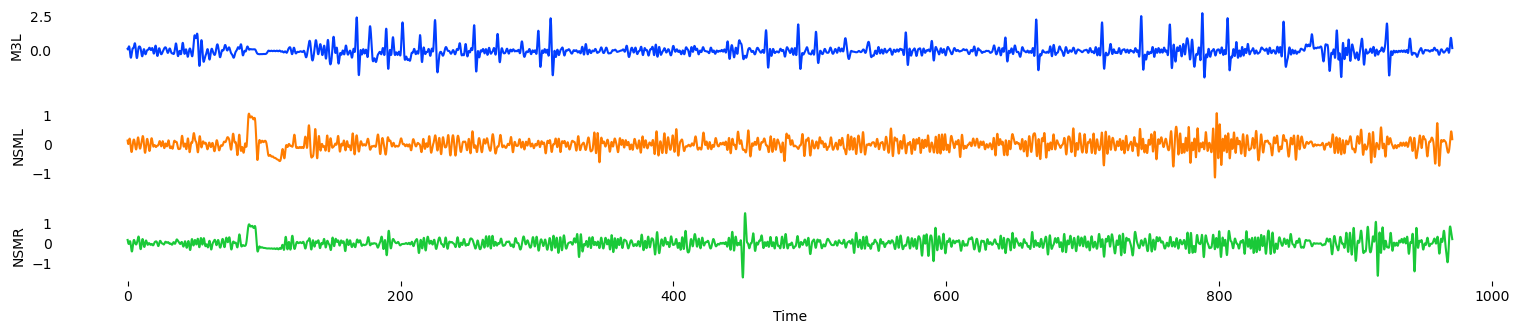

worm3


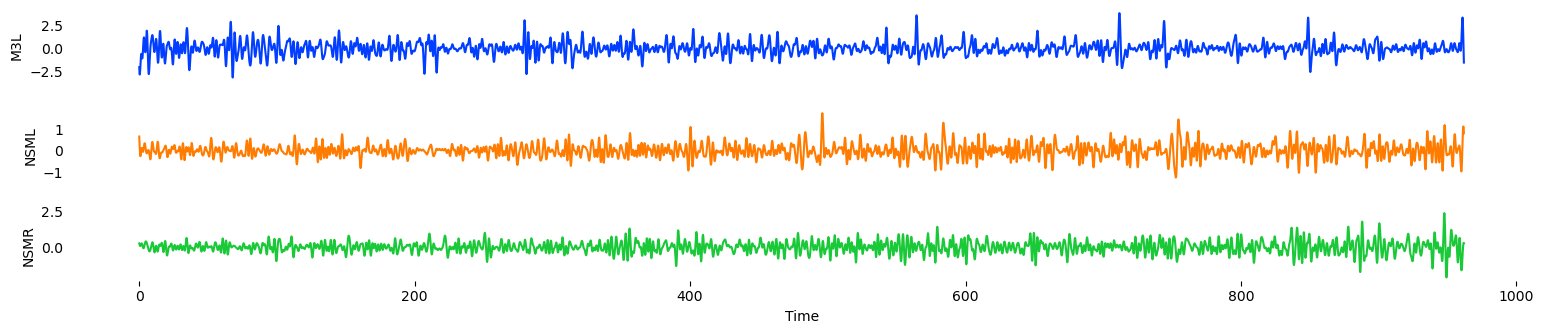

worm4


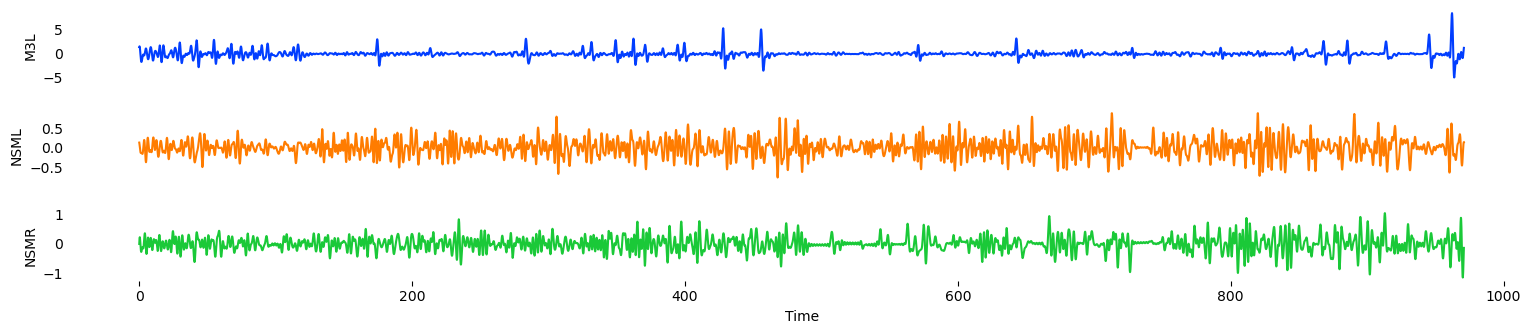

In [ ]:
for wormID in df['wormID'].iloc[:3]:
    print(wormID)
    data = dataset[wormID]
    plot_signals(data['smooth_residual_calcium'], data['time_in_seconds'], [data['named_neuron_to_slot']['M3L'], data['named_neuron_to_slot']['NSML'], data['named_neuron_to_slot']['NSMR']], yax_limit=False)

# Causality (Granger causality test)
---

The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another. Ordinarily, regressions reflect "mere" correlations, but Clive Granger argued that causality in economics could be reflected by measuring the ability to predict the future values of a time series using prior values of another time series.

A low p-value (typically ≤ 0.05) indicates strong evidence that the lags of the second time series in the test cause the time series in the first.

Please note that this conclusion is based on the assumption that the time series are stationary. If they are not, the series should be transformed to become stationary before conducting the Granger causality test.

> If all p-values < 0.05, there is granger causality! => TRUE

# Simple LSTM Model
---

Can I predict NSML dynamics based on M3L dynamics?
> => I'll use the the residual calcium data that is stationary

In [ ]:
class MyNeuralActivityDataset(torch.utils.data.Dataset):
    """A custom neural activity time-series prediction dataset.

    Using NeuralActivityDataset will ensure that sequences are generated
    in a principled and deterministic way, and that every sample
    generated is unique. A map-style dataset implements the `__getitem__()`
    and `__len__()` protocols, and represents a map from indices/keys to
    data samples. Accesing with `dataset[idx]` reads the `idx`-th time-series
    and the corresponding target from memory.

    Notes
    -----
    * The generated samples can have overlapped time steps
    * MODIFIED to select source and target neurons
    """

    def __init__(
        self,
        data,
        seq_len=100,
        num_samples=100,
        source_neurons=None,
        target_neurons=None,
        time_vec=None,
        reverse=False,
        tau=0,
    ):
        """Initializes a new instance of the NeuralActivityDataset.

        Parameters
        ----------
        data : torch.tensor
            Data with shape (max_timesteps, num_neurons).
        seq_len : int, default=1
            Sequences of length `seq_len` are generated until the dataset
            size is achieved.
        num_samples : int, default=100
            Total number of (input, target) data pairs to generate.
            0 < num_samples <= max_timesteps
        source_neurons : None, int or array-like, default=None
            Index of neuron(s) to return data for. Returns data for all
            neurons if None.
        time_vec : None or array-like, default=None
            A vector of the time (in seconds) corresponding to the time
            axis (axis=0) of the `data` tensor.
        reverse : bool, default=False
            Whether to sample sequences backward from end of the data.
        tau : int, default=1
            The number of timesteps to the right by which the target
            sequence is offset from input sequence (time lag).
            0 < tau < max_timesteps//2

        Returns
        -------
        (X, Y, metadata) : tuple
            Batch of data samples, where
        X : torch.tensor
            Input tensor with shape (batch_size, seq_len, num_neurons)
        Y: torch.tensor
            Target tensor with same shape as X
        metadata : dict
            Metadata information about samples.
            keys: 'seq_len', 'start' index , 'end' index
        """

        super(MyNeuralActivityDataset, self).__init__()

        # Check the inputs
        assert torch.is_tensor(data), "Recast the data as type `torch.tensor`."
        assert data.ndim == 2, "Reshape the data tensor as (time, neurons)"
        assert isinstance(seq_len, int) and 0 < seq_len <= data.size(
            0
        ), "Enter an integer sequence length 0 < `seq_len` <= max_timesteps."
        assert (
            isinstance(tau, int) and 0 <= tau < data.size(0) // 2
        ), "Enter a integer offset `0 <= tau < max_timesteps // 2`."

        # Create time vector if not provided
        if time_vec is not None:
            assert torch.is_tensor(
                time_vec
            ), "Recast the time vector as type `torch.tensor`."
            assert time_vec.squeeze().ndim == 1 and len(time_vec) == data.size(
                0
            ), "Time vector must have shape (len(data), )"
            self.time_vec = time_vec.squeeze()
        else:
            self.time_vec = torch.arange(data.size(0)).double()

        self.max_timesteps, num_neurons = data.shape
        self.seq_len = seq_len
        self.reverse = reverse
        self.tau = tau

        # Select out requested neurons
        if source_neurons is not None:
            self.source_neurons = np.array(source_neurons)  # use the subset of neurons given
        else:  # neurons is None
            self.source_neurons = np.arange(num_neurons)  # use all the neurons

        self.num_neurons = self.source_neurons.size
        self.data = data
        self.num_samples = num_samples
        self.target_neurons = target_neurons
        self.data_samples = self.__data_generator()

        assert self.num_samples == len(
            self.data_samples
        ), "Wrong number of sequences generated!"

    def __len__(self):
        """Denotes the total number of samples."""
        return self.num_samples

    def __getitem__(self, index):
        """Generates one sample of data."""
        return self.data_samples[index]

    def parfor_func(self, start):
        """Helper function for parallelizing `__data_generator`.

        This function is applied to each `start` index in the
        `__data_generator` method.
        """

        # Define an end index
        end = start + self.seq_len
        # Get the time vector
        time_vec = self.time_vec[start:end].detach().clone()
        # Calculate the average dt
        avg_dt = torch.diff(time_vec).mean()

        # Data samples: input (X_tau) and target (Y_tau)
        X_tau = self.data[start:end, self.source_neurons].detach().clone()
        Y_tau = (
            self.data[start + self.tau : end + self.tau, self.target_neurons].detach().clone()
        )  # Overlap

        metadata = dict(
            seq_len=self.seq_len,
            start=start,
            end=end,
            tau=self.tau,
            avg_dt=avg_dt,
            time_vec=time_vec,
        )

        # Return sample
        return X_tau, Y_tau, metadata

    def __data_generator(self):
        """Private method for generating data samples.

        This function split the data into sequences of length `seq_len`
        by calling `parfor_func` in parallel.

        Notes
        -----
        * The samples can have overlapped time steps

        """

        # Define length of time
        T = self.max_timesteps
        # Dataset will contain sequences of length `seq_len`
        L = self.seq_len

        # All start indices
        start_range = (
            np.linspace(0, T - L - self.tau, self.num_samples, dtype=int)
            if not self.reverse  # generate from start to end
            else np.linspace(  # generate from end to start
                T - L - self.tau, 0, self.num_samples, dtype=int
            )
        )
        # Sequential processing (applying the function to each element)
        data_samples = list(map(self.parfor_func, start_range))

        return data_samples

In [ ]:
def get_data(dataset, wormID, source_neurons, target_neurons, use_residual=False):
    data = dataset[wormID]
    # Verify if we have the neurons in the dataset
    for neuron in source_neurons:
        assert neuron in data['named_neuron_to_slot'], f'Neuron {neuron} not found in dataset'

    for neuron in target_neurons:
            assert neuron in data['named_neuron_to_slot'], f'Neuron {neuron} not found in dataset'

    source_neurons_idx = [data['named_neuron_to_slot'][neuron] for neuron in source_neurons]
    target_neurons_idx = [data['named_neuron_to_slot'][neuron] for neuron in target_neurons]

    if use_residual:
        calcium_data = data['smooth_residual_calcium']
    else:
        calcium_data = data['smooth_calcium_data']

    time_vector = data['time_in_seconds']
    
    return time_vector, calcium_data, source_neurons_idx, target_neurons_idx

In [ ]:
def split_train_test(dict_dataset, wormIDs, source_neurons, target_neurons, use_residual, samples_per_worm, seq_len, tau, batch_size=32):

    """
    Build a big dataset with all the wormIDs and split it into train and test
    """

    all_datasets = []

    # Loop over all wormIDs
    for wormID in wormIDs:
        # Get the data
        time_vector, calcium_data, source_neurons_idx, target_neurons_idx = get_data(dict_dataset, wormID, source_neurons, target_neurons, use_residual)
        all_datasets.append(MyNeuralActivityDataset(
            data=calcium_data,
            seq_len=seq_len,
            num_samples=samples_per_worm,
            source_neurons=source_neurons_idx,
            target_neurons=target_neurons_idx,
            time_vec=time_vector,
            reverse=False,
            tau=tau,
        ))
    
    all_datasets = ConcatDataset(all_datasets)
    train_set, test_set = random_split(all_datasets, [0.7, 0.3])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
    
    return train_loader, test_loader

In [ ]:
wormIDs = df['wormID'].values.tolist()
source_neurons = ['M3L']
target_neurons = ['NSML']

train_loader, test_loader = split_train_test(dataset, wormIDs, source_neurons, target_neurons, use_residual=False, seq_len=500, samples_per_worm=100, tau=0)

In [ ]:
x, y, metadata = next(iter(train_loader))
x.shape, y.shape

(torch.Size([32, 500, 1]), torch.Size([32, 500, 1]))

Using device: cuda
Epoch 0/200, Train Loss: 0.0611, Test Loss: 0.06087
Epoch 10/200, Train Loss: 0.0607, Test Loss: 0.06074
Epoch 20/200, Train Loss: 0.05956, Test Loss: 0.06065
Epoch 30/200, Train Loss: 0.0598, Test Loss: 0.06068
Epoch 40/200, Train Loss: 0.05971, Test Loss: 0.0607
Epoch 50/200, Train Loss: 0.05974, Test Loss: 0.0606
Epoch 60/200, Train Loss: 0.05961, Test Loss: 0.06063
Epoch 70/200, Train Loss: 0.05992, Test Loss: 0.06048
Epoch 80/200, Train Loss: 0.05973, Test Loss: 0.06062
Epoch 90/200, Train Loss: 0.05961, Test Loss: 0.06092
Epoch 100/200, Train Loss: 0.0603, Test Loss: 0.06081
Epoch 110/200, Train Loss: 0.05966, Test Loss: 0.06059
Epoch 120/200, Train Loss: 0.05926, Test Loss: 0.06082
Epoch 130/200, Train Loss: 0.05987, Test Loss: 0.06056
Epoch 140/200, Train Loss: 0.05951, Test Loss: 0.06055
Epoch 150/200, Train Loss: 0.05928, Test Loss: 0.06059
Epoch 160/200, Train Loss: 0.05842, Test Loss: 0.06048
Epoch 170/200, Train Loss: 0.05828, Test Loss: 0.06072
Epoch 18

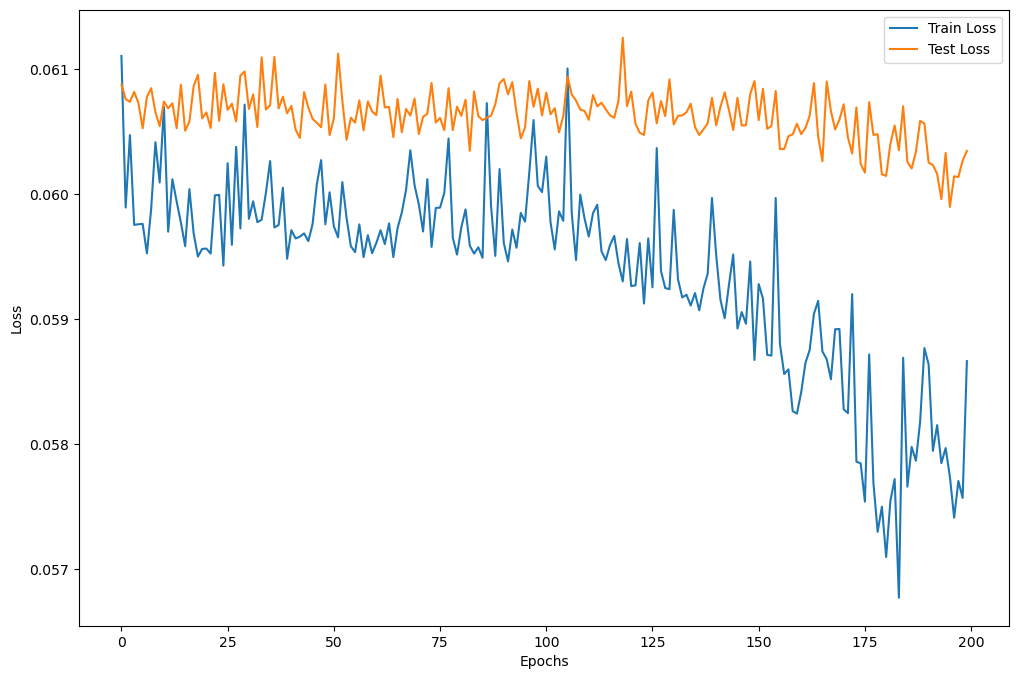

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(LSTMModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(x.device)
            
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out

# Assuming you have your training and testing data prepared...
# input_dim corresponds to the number of features (1 in this case)
# hidden_dim can be chosen based on the complexity of your task, let's say 32
# output_dim is again 1 as we are predicting a single value at each timestep
# n_layers is the number of LSTM layers in the network

input_dim = 1
hidden_dim = 64
output_dim = 1
n_layers = 3
model = LSTMModel(input_dim, hidden_dim, output_dim, n_layers).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.01)

# Prepare data for PyTorch (ensure your data is in PyTorch tensor format)
wormIDs = df['wormID'].values.tolist()
source_neurons = ['M3L']
target_neurons = ['NSML']

train_loader, test_loader = split_train_test(dataset, wormIDs, source_neurons, target_neurons, use_residual=True, seq_len=500, samples_per_worm=100, tau=0)

# Training loop
train_loss = []
test_loss = []

for epoch in range(200):
    model.train()
    epoch_losses = []
    for i, (x_batch, y_batch, metadata) in enumerate(train_loader):

        # Move data to GPU
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(x_batch)
        loss = criterion(predictions, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    train_loss.append(np.mean(epoch_losses))

    # After each epoch, calculate the test loss
    model.eval()
    epoch_losses = []
    with torch.no_grad():
        for i, (test_x, test_y, metadata) in enumerate(test_loader):
            test_x = test_x.to(device)
            test_y = test_y.to(device)
            predictions = model(test_x)
            loss = criterion(predictions, test_y)
            epoch_losses.append(loss.item())
        test_loss.append(np.mean(epoch_losses))

    if epoch % 10 == 0:
        print(f'Epoch {epoch}/{200}, Train Loss: {round(train_loss[-1], 5)}, Test Loss: {round(test_loss[-1], 5)}')

# Plot the train and test loss
plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

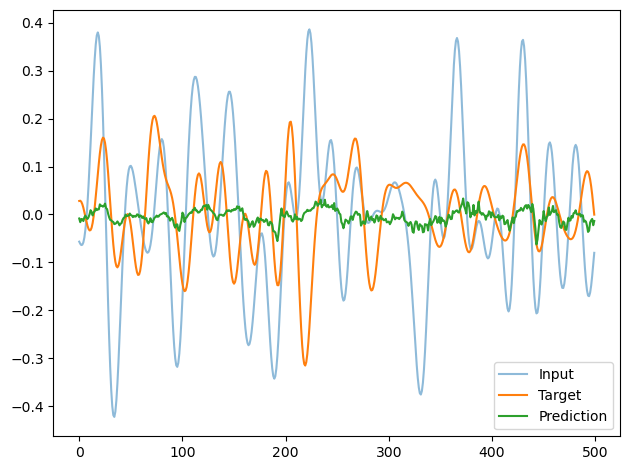

In [ ]:
x, y, _ = next(iter(test_loader))
plt.plot(x[0, :, 0].cpu().numpy(), label='Input', alpha=0.5)
plt.plot(y[0, :, 0].cpu().numpy(), label='Target')
y_pred = model(x.to(device))
plt.plot(y_pred[0, :, 0].cpu().detach().numpy(), label='Prediction')
plt.tight_layout()
plt.legend()
plt.show()

# Governing equations
---

What are the governing equations considering just the M3L, NSML and NSMR neurons?

> *"Understanding the governing equations of complex dynamical systems like neural activity is a challenging task. Typically, these systems are often best described by nonlinear differential equations. One promising approach for discovering these equations from data is the use of methods from the field of machine learning and symbolic regression."*

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# TODO: review
def plot_fourier_spectrum(time_series, sampling_rate):
    """
    Plot the Fourier spectrum of a time series.

    Args:
        time_series (array-like): Time series data.
        sampling_rate (float): Sampling rate of the time series.

    Returns:
        None

    """

    # Compute the Discrete Fourier Transform (DFT)
    dft = np.fft.fft(time_series)

    # Compute the frequencies corresponding to the DFT
    frequencies = np.fft.fftfreq(len(time_series), d=1/sampling_rate)

    # Compute the magnitude spectrum
    magnitude_spectrum = np.abs(dft)

    # Plot the Fourier spectrum
    plt.figure(figsize=(8, 5))
    plt.plot(frequencies, magnitude_spectrum)
    plt.title('Fourier Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    #plt.xlim(0, sampling_rate / 2)
    plt.grid(True)
    plt.show()

In [ ]:
wormIDs = df['wormID'].values.tolist()
source_neurons = ['M3L']
target_neurons = ['NSML', 'NSMR']

train_loader, test_loader = split_train_test(dataset, wormIDs, source_neurons, target_neurons, use_residual=False, seq_len=50, samples_per_worm=500, tau=0)

In [ ]:
def get_pysindy_data(train_loader):
    x, y, metadata = next(iter(train_loader))
    x = x.cpu().numpy()
    y = y.cpu().numpy()
    data = np.hstack((x[0,:,:], y[0,:,:]))
    time_vec = metadata['time_vec'][0,:].cpu().numpy()
    return data, time_vec

data, time_vec = get_pysindy_data(train_loader)

In [ ]:
data.shape

(50, 3)

In [ ]:
import numpy as np
import pysindy as ps
from pysindy.feature_library import PolynomialLibrary, FourierLibrary, CustomLibrary, ConcatLibrary

# Assuming data is a numpy array of shape (n_samples, n_features)
# where n_samples is the number of time steps and n_features is 3 (for M3L, NSML, NSMR)
# t is the array of time values

# Define a differentiation method
diff_method = ps.differentiation.FiniteDifference()

# Define a feature library
feature_library = FourierLibrary(n_frequencies=2)

# Define the optimizer (STLSQ with a threshold)
optimizer = ps.optimizers.STLSQ(threshold=0.02)

# Define the model
model = ps.SINDy(
    differentiation_method=diff_method,
    feature_library=feature_library,
    optimizer=optimizer
)

# Fit the model
model.fit(data, t=time_vec)

# Print the model
print(model)

# To simulate the model
t_sim = np.linspace(time_vec[0], time_vec[-1], 50)
data_sim = model.simulate(data[0, :], t_sim)

# You can now plot data_sim to visualize the results

SINDy(differentiation_method=FiniteDifference(),
      feature_library=<pysindy.feature_library.fourier_library.FourierLibrary object at 0x7f650c226670>,
      feature_names=['x0', 'x1', 'x2'], optimizer=STLSQ(threshold=0.02))


In [ ]:
model.print()

(x0)' = -204.531 sin(1 x0) + 203.719 cos(1 x0) + -187.395 sin(1 x1) + 353.602 cos(1 x1) + 296.242 sin(1 x2) + -664.735 cos(1 x2) + 77.716 sin(2 x0) + -0.282 cos(2 x0) + 80.021 sin(2 x1) + -46.348 cos(2 x1) + -158.608 sin(2 x2) + 132.713 cos(2 x2)
(x1)' = 29.347 sin(1 x0) + -59.603 cos(1 x0) + 27.458 sin(1 x1) + -52.364 cos(1 x1) + -115.198 sin(1 x2) + 57.414 cos(1 x2) + -15.112 sin(2 x0) + 10.758 cos(2 x0) + -12.644 sin(2 x1) + 10.232 cos(2 x1) + 31.571 sin(2 x2) + 20.268 cos(2 x2)
(x2)' = 156.771 sin(1 x0) + -180.007 cos(1 x0) + 92.409 sin(1 x1) + -212.451 cos(1 x1) + -259.149 sin(1 x2) + 408.999 cos(1 x2) + -63.341 sin(2 x0) + 9.168 cos(2 x0) + -38.776 sin(2 x1) + 32.766 cos(2 x1) + 116.236 sin(2 x2) + -54.349 cos(2 x2)


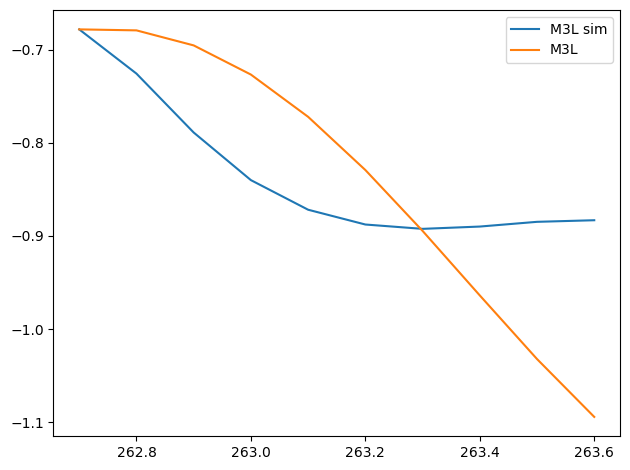

In [ ]:
plt.plot(t_sim[:10], data_sim[:10, 0], label='M3L sim')
#plt.plot(t_sim, data_sim[:, 1], label='NSML sim')
plt.plot(t_sim[:10], data[:10, 0], label='M3L')
plt.tight_layout()
plt.legend()
plt.show()

# 1D convolution filter to detect correlation between signals?
---

Your approach sounds like an interesting way to extract temporal features and relationships between time series. The use of convolutional layers is beneficial as they can effectively capture local temporal dependencies. And by associating the outputs of these convolutions with the Dynamic Time Warping (DTW) distance, you're essentially training your network to learn a function that approximates DTW distance. 

Here's a more detailed understanding of your idea:

- You're proposing a supervised learning setup where the inputs are pairs of time series segments and the targets are the DTW distances between these segments.
- By training a 1D Convolutional Neural Network (CNN) on these inputs and targets, you're hoping that the network will learn to recognize patterns that are indicative of low or high DTW distance.
- Once trained, this network could be used to quickly estimate the DTW distance between two time series segments without needing to actually compute the DTW distance, which can be computationally expensive.

This is an interesting approach. It's similar in spirit to techniques used in areas like metric learning or representation learning, where the goal is to learn a useful measure of distance or similarity for complex data. Here, you're applying it to the task of time series analysis, which seems novel.

In terms of whether this will help you model the neurons in the future, it's difficult to say without trying it out. The learned convolutional filters would essentially be extracting features that are relevant for approximating DTW distance. Whether these features are also useful for predicting neural activity depends on the specific characteristics of your data.

However, the model could certainly be useful in exploratory data analysis, for instance in identifying similar segments of neural activity or detecting anomalies. The learned features might also be used as input to other models for predicting neural activity.

The idea definitely has potential, and it could be worth implementing and testing to see what kind of results you get. It's always valuable to try different approaches when dealing with complex tasks like modeling neural activity.

In [ ]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean


class DTWdataset(torch.utils.data.Dataset):
    """A custom neural activity time-series prediction dataset.

    Using NeuralActivityDataset will ensure that sequences are generated
    in a principled and deterministic way, and that every sample
    generated is unique. A map-style dataset implements the `__getitem__()`
    and `__len__()` protocols, and represents a map from indices/keys to
    data samples. Accesing with `dataset[idx]` reads the `idx`-th time-series
    and the corresponding target from memory.

    Notes
    -----
    * The generated samples can have overlapped time steps
    * MODIFIED to compute DTW distance between source and target neurons
    """

    def __init__(
        self,
        data,
        seq_len=100,
        num_samples=100,
        source_neurons=None,
        target_neurons=None,
        time_vec=None,
        reverse=False,
        tau=0,
    ):
        """Initializes a new instance of the NeuralActivityDataset.

        Parameters
        ----------
        data : torch.tensor
            Data with shape (max_timesteps, num_neurons).
        seq_len : int, default=1
            Sequences of length `seq_len` are generated until the dataset
            size is achieved.
        num_samples : int, default=100
            Total number of (input, target) data pairs to generate.
            0 < num_samples <= max_timesteps
        source_neurons : None, int or array-like, default=None
            Index of neuron(s) to return data for. Returns data for all
            neurons if None.
        time_vec : None or array-like, default=None
            A vector of the time (in seconds) corresponding to the time
            axis (axis=0) of the `data` tensor.
        reverse : bool, default=False
            Whether to sample sequences backward from end of the data.
        tau : int, default=1
            The number of timesteps to the right by which the target
            sequence is offset from input sequence (time lag).
            0 < tau < max_timesteps//2

        Returns
        -------
        (X, Y, metadata) : tuple
            Batch of data samples, where
        X : torch.tensor
            Input tensor with shape (batch_size, seq_len, num_neurons)
        Y: torch.tensor
            Target tensor with same shape as X
        metadata : dict
            Metadata information about samples.
            keys: 'seq_len', 'start' index , 'end' index
        """

        super(MyNeuralActivityDataset, self).__init__()

        # Check the inputs
        assert torch.is_tensor(data), "Recast the data as type `torch.tensor`."
        assert data.ndim == 2, "Reshape the data tensor as (time, neurons)"
        assert isinstance(seq_len, int) and 0 < seq_len <= data.size(
            0
        ), "Enter an integer sequence length 0 < `seq_len` <= max_timesteps."
        assert (
            isinstance(tau, int) and 0 <= tau < data.size(0) // 2
        ), "Enter a integer offset `0 <= tau < max_timesteps // 2`."

        # Create time vector if not provided
        if time_vec is not None:
            assert torch.is_tensor(
                time_vec
            ), "Recast the time vector as type `torch.tensor`."
            assert time_vec.squeeze().ndim == 1 and len(time_vec) == data.size(
                0
            ), "Time vector must have shape (len(data), )"
            self.time_vec = time_vec.squeeze()
        else:
            self.time_vec = torch.arange(data.size(0)).double()

        self.max_timesteps, num_neurons = data.shape
        self.seq_len = seq_len
        self.reverse = reverse
        self.tau = tau

        # Select out requested neurons
        if source_neurons is not None:
            self.source_neurons = np.array(source_neurons)  # use the subset of neurons given
        else:  # neurons is None
            self.source_neurons = np.arange(num_neurons)  # use all the neurons

        self.num_neurons = self.source_neurons.size
        self.data = data
        self.num_samples = num_samples
        self.target_neurons = target_neurons
        self.data_samples = self.__data_generator()

        assert self.num_samples == len(
            self.data_samples
        ), "Wrong number of sequences generated!"

    def __len__(self):
        """Denotes the total number of samples."""
        return self.num_samples

    def __getitem__(self, index):
        """Generates one sample of data."""
        return self.data_samples[index]

    def parfor_func(self, start):
        """Helper function for parallelizing `__data_generator`.

        This function is applied to each `start` index in the
        `__data_generator` method.
        """

        # Define an end index
        end = start + self.seq_len
        # Get the time vector
        time_vec = self.time_vec[start:end].detach().clone()
        # Calculate the average dt
        avg_dt = torch.diff(time_vec).mean()

        # Data samples: input (X_tau) and target (Y_tau)
        X_tau = self.data[start:end, self.source_neurons].detach().clone()
        Y_tau = (
            self.data[start + self.tau : end + self.tau, self.target_neurons].detach().clone()
        )  # Overlap

        metadata = dict(
            seq_len=self.seq_len,
            start=start,
            end=end,
            tau=self.tau,
            avg_dt=avg_dt,
            time_vec=time_vec,
        )

        # Return sample
        return X_tau, Y_tau, metadata

    def __data_generator(self):
        """Private method for generating data samples.

        This function split the data into sequences of length `seq_len`
        by calling `parfor_func` in parallel.

        Notes
        -----
        * The samples can have overlapped time steps

        """

        # Define length of time
        T = self.max_timesteps
        # Dataset will contain sequences of length `seq_len`
        L = self.seq_len

        # All start indices
        start_range = (
            np.linspace(0, T - L - self.tau, self.num_samples, dtype=int)
            if not self.reverse  # generate from start to end
            else np.linspace(  # generate from end to start
                T - L - self.tau, 0, self.num_samples, dtype=int
            )
        )
        # Sequential processing (applying the function to each element)
        data_samples = list(map(self.parfor_func, start_range))

        return data_samples

def create_labels(ts1, ts2, window_size):
    """
    Function to create DTW distance labels for two time series.
    
    Arguments:
    ts1, ts2 -- input time series
    window_size -- size of the window to scan the time series
    
    Returns:
    labels -- array of DTW distances
    """
    # Initialize labels
    labels = []
    
    # Loop over windows
    for i in range(0, len(ts1) - window_size + 1):
        # Calculate DTW distance for each window
        window_ts1 = ts1[i:i + window_size].reshape(-1, 1)
        window_ts2 = ts2[i:i + window_size].reshape(-1, 1)
        distance, _ = fastdtw(window_ts1, window_ts2, dist=euclidean)
        
        # Append distance to labels
        labels.append(distance)
        
    return np.array(labels)

In [ ]:
x, y, _ = next(iter(train_loader))

In [ ]:
x[0, :, 0].cpu().numpy().shape

(500,)

In [ ]:
create_labels(x[0, :, 0].cpu().numpy(), y[0, :, 0].cpu().numpy(), 100).shape

(401,)